In [ ]:
!pip install imdbpy

     |████████████████████████████████| 307kB 8.6MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from google.colab import drive
drive.mount('/content/drive')
from functools import partial
from imdb import IMDb
from tqdm import tqdm

Mounted at /content/drive


In [ ]:
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
!ls "/content/drive/My Drive/Term_Project_Unsupervised_Learners/data/"
path = "/content/drive/My Drive/Term_Project_Unsupervised_Learners/data/"
f_path = "/content/drive/My Drive/Term_Project_Unsupervised_Learners/feature/"

 aggregated_1119.csv
'aggregated_aggregated (1).gsheet'
 aggregated_aggregated.csv
 aggregated_aggregated.gsheet
 aggregated.csv
 aggregated_genre_collection_actor_istopk_logrev.csv
 aggregated_genre_collection_actor_istopk_logrev.gsheet
 aggregated_genre_collection.csv
 aggregated_logbudget_titlelength.csv
 aggregated_new.csv
 aggregated_pd_companies.csv
'aggregated_us_only (1).csv'
 aggregated_us_only.csv
 budget_revenue.csv
 budget_revenue.gsheet
 budget_revenue_imdb.csv
 budget_revenue_imdb_filled.csv
 budget_revenue_imdb.gsheet
 credits_new.csv
 final_aggregate.csv
 movie_new.csv
 original_data
 oscars.csv
 test_2015_2017.csv
 train_1980_2012.csv
 val_2013_2014.csv


In [ ]:
df = pd.read_csv(path+'aggregated_genre_collection_actor_istopk_logrev.csv',index_col=None)

In [ ]:
ia = IMDb()
def getAttr(idx,attr):
    movie = ia.get_movie(idx)
    ia.update(movie)
    if attr in movie.keys():
        # print(movie['box office'])
        return movie[attr]
    else: return 'None'
imdb_id = [row.strip('tt') for row in df['imdb_id']]

In [ ]:
budget_revenue=df[['id','budget_','revenue','title','imdb_id','release_date']][np.where(df['revenue'] < 10000,True,False) | np.where(df['budget']< 10000,True,False)].sort_values(['revenue','budget'])

In [ ]:
budget_revenue.reset_index(inplace=True,drop=True)
budget_revenue

,id,budget,revenue,title,imdb_id,release_date
0,218275,1.0,1.0,The Letters,tt1445208,2015-12-04
1,48787,2.0,1.0,Mute Witness,tt0110604,1995-09-28
2,53230,592.0,1.0,The Merry Widow,tt0016104,1925-08-26
3,51352,20000000.0,1.0,Anne Frank Remembered,tt0112373,1995-06-08
4,45019,20000000.0,1.0,Washington Square,tt0120481,1997-10-10
...,...,...,...,...,...,...
119,50217,93.0,2500000.0,From Prada to Nada,tt0893412,2011-01-28
120,3082,1.0,8500000.0,Modern Times,tt0027977,1936-02-05
121,78383,10.0,10000000.0,Nurse 3-D,tt1913166,2013-09-28
122,13703,1.0,12396383.0,Less Than Zero,tt0093407,1987-11-06


In [ ]:
imdb_id_reduced = [row.strip('tt') for row in budget_revenue['imdb_id']]

In [ ]:
gross = [getAttr(idx,'box office') for idx in tqdm(imdb_id_reduced)]

100%|██████████| 124/124 [02:52<00:00,  1.35s/it]









100%|██████████| 124/124 [02:52<00:00,  1.39s/it]


In [ ]:
budget_revenue['gross'] = gross

In [ ]:
def stripGross(old,new,strip):
    budget_new = []
    for idx in range(len(gross)):
        row = gross[idx]
        if type(row) == dict:
            if new in row.keys():
                string = row[new].strip(strip).replace(',','')
                budget_new.append(string)
            else: budget_new.append(budget_revenue[old][idx])
        else: budget_new.append(budget_revenue[old][idx])
    return budget_new

budget_revenue['budget_new'] = stripGross('budget','Budget','$(estimated)')
budget_revenue['cum_worldwide'] = stripGross('revenue','Cumulative Worldwide Gross','$')

In [ ]:
def stripOpening(old,new):
    budget_new = []
    for idx in range(len(gross)):
        row = gross[idx]
        if type(row) == dict:
            if new in row.keys():
                string = row[new].strip('$')
                i = row[new].rfind(',')
                string = string[:i-1].replace(',','')
                budget_new.append(string)
            else: budget_new.append(budget_revenue[old][idx])
        else: budget_new.append(budget_revenue[old][idx])
    return budget_new
budget_revenue['opening_weekend'] = stripOpening('revenue','Opening Weekend United States')

In [ ]:
# budget_revenue.to_csv(path+'budget_revenue_imdb.csv',index=None)

In [ ]:
# awards=[ia.get_movie_awards(idx)['data'] for idx in tqdm(imdb_id)]

In [ ]:
df['budget_new'] = df['budget']
df['revenue_new'] = df['revenue']

In [ ]:
budget_revenue_filled = pd.read_csv(path+'budget_revenue_imdb_filled.csv',index_col=None)
budget_revenue_filled

,id,budget,revenue,title,imdb_id,release_date,gross,budget_new,budget_final,opening_weekend,cum_worldwide,revenue_final
0,218275,1,1,The Letters,tt1445208,2015-12-04,"{'Budget': '$20,000,000 (estimated)', 'Opening...",20000000,20000000.0,700683,1,700683.0
1,48787,2,1,Mute Witness,tt0110604,1995-09-28,"{'Budget': '$2,000,000 (estimated)'}",2000000,2000000.0,1,1,1125910.0
2,53230,592,1,The Merry Widow,tt0016104,1925-08-26,"{'Budget': '$608,016 (estimated)', 'Cumulative...",608016,608016.0,1,4142000,4142000.0
3,51352,20000000,1,Anne Frank Remembered,tt0112373,1995-06-08,None,20000000,20000000.0,1,1,1310200.0
4,45019,20000000,1,Washington Square,tt0120481,1997-10-10,"{'Opening Weekend United States': '$14,352, 05...",20000000,20000000.0,14352,1,14352.0
...,...,...,...,...,...,...,...,...,...,...,...,...
119,50217,93,2500000,From Prada to Nada,tt0893412,2011-01-28,None,93,NaN,2500000,2500000,4072098.0
120,3082,1,8500000,Modern Times,tt0027977,1936-02-05,"{'Budget': '$1,500,000 (estimated)', 'Opening ...",1500000,1500000.0,11507,8500000,8500000.0
121,78383,10,10000000,Nurse 3-D,tt1913166,2013-09-28,"{'Budget': '$10,000,000 (estimated)'}",10000000,10000000.0,10000000,10000000,10000000.0
122,13703,1,12396383,Less Than Zero,tt0093407,1987-11-06,"{'Opening Weekend United States': '$3,008,987,...",1,8000000.0,3008987,12396383,12396383.0


In [ ]:
new_bud_rev = budget_revenue_filled[['id','budget_final','revenue_final']]
for id in new_bud_rev['id']:
    idx = df.loc[df['id']==id].index
    df.at[idx,'budget_new'] = new_bud_rev.loc[new_bud_rev['id'] == id]['budget_final'].values[0]
    df.at[idx,'revenue_new'] = new_bud_rev.loc[new_bud_rev['id'] == id]['revenue_final'].values[0]

In [ ]:
for id in new_bud_rev['id']:
    idx = df.loc[df['id']==id].index
    df.at[idx,'budget_old_new'] = new_bud_rev.loc[new_bud_rev['id'] == id]['budget_final'].values[0]

In [ ]:
df_old = pd.read_csv(path+'aggregated.csv')
df['budget_old_new'] = df_old.set_index('id').loc[df['id']]['budget'].values

In [ ]:
df['budget_old_new']= df['budget_old_new'].fillna(0)

In [ ]:
temp = df[df['budget_old_new']==0][['id','imdb_id','budget_old_new']]

In [ ]:
temp['budget_scrape'] = temp['budget_old_new']
temp.reset_index(inplace=True,drop=True)
temp['budget_scrape'] = temp['budget_scrape'].astype('object')
temp.dtypes

id                  int64
imdb_id            object
budget_old_new    float64
budget_scrape      object
dtype: object

In [ ]:
missing_imdb_id = temp.imdb_id

In [ ]:
gross1 = [getAttr(id.strip('tt'),'box office') for id in tqdm(missing_imdb_id.values)]

100%|██████████| 1178/1178 [33:52<00:00,  1.73s/it]


In [ ]:
for idx,row in enumerate(gross1):
    if type(row) == dict: 
        if 'Budget' in row.keys():
            temp.at[idx, 'budget_scrape'] = row['Budget'].strip('$(estimated)').replace(',','')
        else: temp.at[idx, 'budget_scrape']= 0
    else: temp.at[idx, 'budget_scrape']=0

temp.to_csv(path+'budget_revenue_all_missing.csv',index=None)

In [ ]:
temp_filled = pd.read_csv(path+'budget_revenue_all_missing_filled.csv',index_col=None)


id                 int64
imdb_id           object
budget_old_new     int64
budget_scrape      int64
dtype: object

In [ ]:
df['budget_final'] = df['budget_old_new']
for id in temp_filled['id']:
    idx = df.loc[df['id']==id].index
    df.at[idx,'budget_final'] = temp_filled.loc[temp_filled['id'] == id]['budget_scrape'].values[0]


In [ ]:
df['release_year'] = pd.DatetimeIndex(df['release_date']).year
new_df = df.drop(df.loc[df['release_year']<1980].index)

In [ ]:
new_df.drop(columns=['budget_old_new','budget_new'],inplace=True)

In [ ]:
new_df[new_df['budget_final']==0]

,id,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,top5_actors,log_revenue,usa,log_revenue_num,first_company,production_company_class,gender_score,has_oscar_winner,log_budget,title_length,Action,Adventure,Animation,Comedy,...,logrev_in_2002-01-01_2003-12-31_3,logrev_in_2002-01-01_2003-12-31_4,logrev_in_2004-01-01_2005-12-31_0,logrev_in_2004-01-01_2005-12-31_1,logrev_in_2004-01-01_2005-12-31_2,logrev_in_2004-01-01_2005-12-31_3,logrev_in_2004-01-01_2005-12-31_4,logrev_in_2006-01-01_2007-12-31_0,logrev_in_2006-01-01_2007-12-31_1,logrev_in_2006-01-01_2007-12-31_2,logrev_in_2006-01-01_2007-12-31_3,logrev_in_2006-01-01_2007-12-31_4,logrev_in_2008-01-01_2009-12-31_0,logrev_in_2008-01-01_2009-12-31_1,logrev_in_2008-01-01_2009-12-31_2,logrev_in_2008-01-01_2009-12-31_3,logrev_in_2008-01-01_2009-12-31_4,logrev_in_2010-01-01_2011-12-31_0,logrev_in_2010-01-01_2011-12-31_1,logrev_in_2010-01-01_2011-12-31_2,logrev_in_2010-01-01_2011-12-31_3,logrev_in_2010-01-01_2011-12-31_4,logrev_in_2002-01-01_2006-12-31_0,logrev_in_2002-01-01_2006-12-31_1,logrev_in_2002-01-01_2006-12-31_2,logrev_in_2002-01-01_2006-12-31_3,logrev_in_2002-01-01_2006-12-31_4,logrev_in_2007-01-01_2011-12-31_0,logrev_in_2007-01-01_2011-12-31_1,logrev_in_2007-01-01_2011-12-31_2,logrev_in_2007-01-01_2011-12-31_3,logrev_in_2007-01-01_2011-12-31_4,logrev_in_2002-01-01_2011-12-31_0,logrev_in_2002-01-01_2011-12-31_1,logrev_in_2002-01-01_2011-12-31_2,logrev_in_2002-01-01_2011-12-31_3,logrev_in_2002-01-01_2011-12-31_4,revenue_new,budget_final,release_year
8,21032,False,"{'id': 117693, 'name': 'Balto Collection', 'po...",20000000.0,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",NaN,tt0112453,en,Balto,An outcast half-wolf risks his life to prevent...,12.140733,/gV5PCAVCPNxlOLFM1bKk50EqLXO.jpg,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,11348324.0,78.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Part Dog. Part Wolf. All Hero.,Balto,False,7.1,423.0,"[{'cast_id': 1, 'character': 'Balto (voice)', ...","[{'credit_id': '593f24b9c3a3680369002371', 'de...","['Kevin Bacon', 'Bob Hoskins', 'Bridget Fonda'...",M,True,16.244581,Universal Pictures,major,0.2,0.0,16.811243,1,0.0,1.0,1.0,0.0,...,17.360599,17.421132,15.358468,17.744806,17.281424,17.209644,17.186005,16.647220,15.177757,16.958927,19.477062,16.791195,14.723583,16.916117,17.229866,17.021555,17.097519,16.186335,16.963018,16.649069,16.486897,16.55299,16.659521,17.190959,17.081469,16.977600,16.978994,15.935868,15.317259,16.812532,17.981980,16.710061,16.246005,16.254109,16.847044,17.981980,16.744449,11348324.0,0.0,1995
37,28387,False,NaN,20000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0113537,en,Kicking and Screaming,"After college graduation, Grover's girlfriend ...",3.367276,/urPxxjylNUHmoNcGkMgHStMTxhF.jpg,"[{'name': 'Castleberg Productions', 'id': 5841...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-06,718490.0,96.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Anxiety loves company.,Kicking and Screaming,False,7.0,36.0,"[{'cast_id': 1, 'character': 'Grover', 'credit...","[{'credit_id': '52fe4592c3a368484e062d3f', 'de...","['Josh Hamilton', ""Olivia d'Abo"", 'Carlos Jaco...",L,True,13.484907,Castleberg Productions,minor,0.2,0.0,16.811243,2,0.0,0.0,0.0,1.0,...,17.360599,17.421132,17.651282,17.429736,17.281424,17.209644,17.186005,17.431418,15.799996,16.958927,16.865996,16.791195,17.500786,17.285917,17.229866,17.021555,17.097519,18.253516,16.963018,16.649069,16.514355,16.55299,17.498172,15.799996,17.081469,16.977600,16.978994,18.253516,16.976320,16.812532,16.669104,16.710061,18.253516,15.799996,16.847044,16.696161,16.744449,718490.0,0.0,1995
38,20927,False,NaN,20000000.0,"[{'id': 18, 'name': 'Drama

In [ ]:
temp_df = new_df.loc[new_df['budget_final']!=0]

In [ ]:
temp_df['production_company_class']

0        minor
1       medium
2        major
3        minor
4       medium
         ...  
5614     minor
5615     minor
5616    medium
5617     major
5618     minor
Name: production_company_class, Length: 4315, dtype: object

In [ ]:
major = temp_df.loc[temp_df['production_company_class']=='major']['budget_final'].median()
medium = temp_df.loc[temp_df['production_company_class']=='medium']['budget_final'].median()
minor = temp_df.loc[temp_df['production_company_class']=='minor']['budget_final'].median()
other = temp_df.loc[pd.isna(temp_df['production_company_class'])]['budget_final'].median()
print(major,medium,minor,other)

32000000.0 25000000.0 15000000.0 3000000.0


In [ ]:
for idx in new_df[new_df['budget_final']==0].index:
    if new_df.loc[idx]['production_company_class'] == 'major':
        new_df.at[idx,'budget_final'] = major
    elif new_df.loc[idx]['production_company_class'] == 'medium':
        new_df.at[idx,'budget_final'] = medium
    elif new_df.loc[idx]['production_company_class'] == 'minor':
        new_df.at[idx,'budget_final'] = minor
    else:
        new_df.at[idx,'budget_final'] = other
        new_df.at[idx,'production_company_class'] = 'other'

In [ ]:
for idx in new_df[pd.isna(new_df['production_company_class'])].index:
    new_df.at[idx,'production_company_class'] = 'other'

In [ ]:
new_df['log_revenue_final'] = np.log(new_df['revenue_new'])
new_df['log_budget_final'] = np.log(new_df['budget_final'])

In [ ]:
new_df.to_csv(path+'aggregated_final_clean.csv',index=None)

In [ ]:
new_df.columns[35:70]

Index(['title_length', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western', 'popular_genre', 'collection_name',
       'collection', 'first_in_collection', 'sequel',
       'is_top100_actors_in_2002-01-01_2003-12-31_0',
       'is_top100_actors_in_2002-01-01_2003-12-31_1',
       'is_top100_actors_in_2002-01-01_2003-12-31_2',
       'is_top100_actors_in_2002-01-01_2003-12-31_3',
       'is_top100_actors_in_2002-01-01_2003-12-31_4',
       'is_top100_actors_in_2004-01-01_2005-12-31_0',
       'is_top100_actors_in_2004-01-01_2005-12-31_1',
       'is_top100_actors_in_2004-01-01_2005-12-31_2',
       'is_top100_actors_in_2004-01-01_2005-12-31_3'],
      dtype='object')

0       False
1       False
2       False
3       False
4       False
        ...  
5614    False
5615    False
5616    False
5617    False
5618    False
Name: top5_actors, Length: 5074, dtype: bool

In [ ]:
keep_columns=['id','title','imdb_id','release_date','release_year','runtime','title_length','top5_actors','log_revenue_final','log_budget_final','revenue_new','budget_final','first_company','production_company_class','gender_score','has_oscar_winner','Action', 'Adventure', 'Animation', 'Comedy', 'Crime','Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History','Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie','Thriller', 'War', 'Western', 'popular_genre', 'collection_name','collection', 'first_in_collection','sequel','crew','cast']
new_df[keep_columns].to_csv(path+'aggregated_selected_columns.csv',index=None)

In [ ]:
train = new_df.loc[new_df['release_year']>=1980].loc[new_df['release_year']<= 2012]
val = new_df.loc[new_df['release_year']>2012].loc[new_df['release_year']<=2014]
test = new_df.loc[new_df['release_year']>2014]
print(train.shape,val.shape,test.shape)

(4163, 146) (429, 146) (482, 146)


In [ ]:
train.to_csv(path+'train_1980_2012.csv',index=False)
val.to_csv(path+'val_2013_2014.csv',index=False)
test.to_csv(path+'test_2015_2017.csv',index=False)

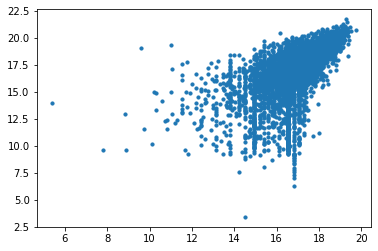

In [ ]:
plt.scatter(np.log(new_df['budget_final']),np.log(new_df['revenue_new']),s=10)

In [ ]:
df = pd.read_csv(path+'aggregated_logbudget_titlelength.csv',index_col=None)
df.drop(columns=['Unnamed: 0','id.1','id'],inplace=True)
df['id'] = df['id.1.1']
df.drop(columns='id.1.1',inplace=True)

In [ ]:
df

,id,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,top5_actors,log_revenue,usa,log_revenue_num,first_company,production_company_class,gender_score,has_oscar_winner,log_budget,title_length,Action,Adventure,Animation,Comedy,...,logrev_in_2002-01-01_2003-12-31_2,logrev_in_2002-01-01_2003-12-31_3,logrev_in_2002-01-01_2003-12-31_4,logrev_in_2004-01-01_2005-12-31_0,logrev_in_2004-01-01_2005-12-31_1,logrev_in_2004-01-01_2005-12-31_2,logrev_in_2004-01-01_2005-12-31_3,logrev_in_2004-01-01_2005-12-31_4,logrev_in_2006-01-01_2007-12-31_0,logrev_in_2006-01-01_2007-12-31_1,logrev_in_2006-01-01_2007-12-31_2,logrev_in_2006-01-01_2007-12-31_3,logrev_in_2006-01-01_2007-12-31_4,logrev_in_2008-01-01_2009-12-31_0,logrev_in_2008-01-01_2009-12-31_1,logrev_in_2008-01-01_2009-12-31_2,logrev_in_2008-01-01_2009-12-31_3,logrev_in_2008-01-01_2009-12-31_4,logrev_in_2010-01-01_2011-12-31_0,logrev_in_2010-01-01_2011-12-31_1,logrev_in_2010-01-01_2011-12-31_2,logrev_in_2010-01-01_2011-12-31_3,logrev_in_2010-01-01_2011-12-31_4,logrev_in_2002-01-01_2006-12-31_0,logrev_in_2002-01-01_2006-12-31_1,logrev_in_2002-01-01_2006-12-31_2,logrev_in_2002-01-01_2006-12-31_3,logrev_in_2002-01-01_2006-12-31_4,logrev_in_2007-01-01_2011-12-31_0,logrev_in_2007-01-01_2011-12-31_1,logrev_in_2007-01-01_2011-12-31_2,logrev_in_2007-01-01_2011-12-31_3,logrev_in_2007-01-01_2011-12-31_4,logrev_in_2002-01-01_2011-12-31_0,logrev_in_2002-01-01_2011-12-31_1,logrev_in_2002-01-01_2011-12-31_2,logrev_in_2002-01-01_2011-12-31_3,logrev_in_2002-01-01_2011-12-31_4,budget_new,revenue_new
0,862.0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...",H,True,19.738573,Pixar Animation Studios,minor,0.0,1.0,17.216708,2.0,0.0,0.0,1.0,1.0,...,17.425870,17.360599,17.421132,19.372588,17.429736,17.281424,17.209644,17.186005,17.795779,17.968400,16.958927,16.865996,16.791195,19.692163,17.285917,17.229866,17.021555,17.097519,18.672968,16.088490,16.649069,16.514355,16.55299,18.705226,17.489011,17.081469,16.977600,16.978994,18.861141,17.176116,16.812532,16.669104,16.710061,18.776097,17.371675,16.847044,16.696161,16.744449,30000000.0,373554033.0
1,8844.0,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","['Robin Williams', 'Jonathan Hyde', 'Kirsten D...",H,True,19.386893,TriStar Pictures,medium,0.4,0.0,17.989898,1.0,0.0,1.0,0.0,0.0,...,16.388854,17.360599,19.063650,14.220347,17.429736,18.780934,17.209644,18.676732,18.410477,17.071542,19.262720,16.865996,19.951039,16.925388,17.285917,17.229866,17.021555,17.097519,17.300818,16.963018,16.649069,16.514355,16.55299,16.871574,17.214330,17.839707,16.977600,19.230474,17.367447,16.976320,20.607711,16.669104,16.710061,17.062295,16.972178,18.235136,16.696161,19.230474,65000000.0,

In [ ]:
def convertListofJsontoList(df,column,ls):
    rl=df[column].tolist()
    for i in df[pd.isna(df[column]) != True].index:
        item=ast.literal_eval(df[column][i])
        
        if ls:
            temp = []
            for j in range(len(item)):
                temp.append(item[j]['name'])
            rl[i]=temp
        else: rl[i] = item['name']
        
    return pd.DataFrame(rl)
genre = convertListofJsontoList(df,'genres',True)
collection = convertListofJsontoList(df,'belongs_to_collection',False)

In [ ]:
## feature - collection; output - new_collection
collection.columns=['collection_name']
collection['collection'] = np.where(pd.isna(collection['collection_name']),0,1)

In [ ]:
collection[['id','release_date']] = df[['id','release_date']]
collection

,collection_name,collection,id,release_date
0,Toy Story Collection,1,862,1995-10-30
1,NaN,0,8844,1995-12-15
2,NaN,0,31357,1995-12-22
3,Father of the Bride Collection,1,11862,1995-02-10
4,NaN,0,949,1995-12-15
...,...,...,...,...
5614,NaN,0,429200,2017-08-11
5615,NaN,0,269795,2017-06-29
5616,NaN,0,353491,2017-08-03
5617,NaN,0,378236,2017-07-28


In [ ]:
first_in_collection = collection.loc[collection['collection']==1].sort_values('release_date').groupby('collection_name').first()['id'].values

In [ ]:
collection['first_in_collection'] = np.where(np.isin(collection['id'], first_in_collection),1,0)
collection['sequel'] = collection['collection'] - collection['first_in_collection']
collection

,collection_name,collection,id,release_date,first_in_collection,sequel
0,Toy Story Collection,1,862,1995-10-30,1,0
1,NaN,0,8844,1995-12-15,0,0
2,NaN,0,31357,1995-12-22,0,0
3,Father of the Bride Collection,1,11862,1995-02-10,0,1
4,NaN,0,949,1995-12-15,0,0
...,...,...,...,...,...,...
5614,NaN,0,429200,2017-08-11,0,0
5615,NaN,0,269795,2017-06-29,0,0
5616,NaN,0,353491,2017-08-03,0,0
5617,NaN,0,378236,2017-07-28,0,0


In [ ]:
new_collection = collection[['collection_name','collection','first_in_collection','sequel']]

In [ ]:
## feature - genre; output - out_genres
# # generate a list of unique genres
# genre_list = list(set([item for col in genre.columns for item in genre[col]]))
# genre_list.remove(None)
# genre_list

In [ ]:
# create dummy variables out of genres
new_genres= pd.get_dummies(genre.stack()).sum(level=0).astype('int')

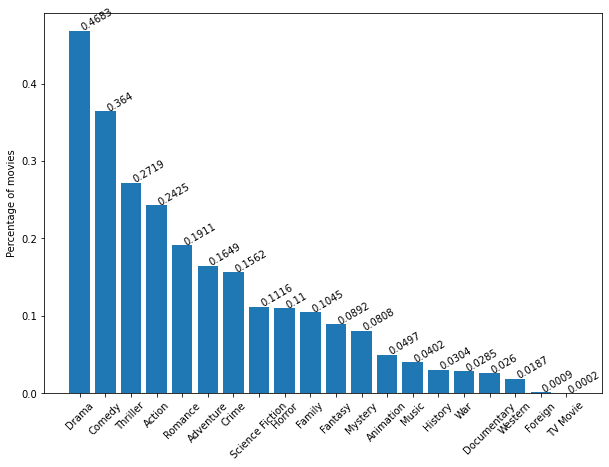

In [ ]:
# plot percentage of movies with feature 
genre_mean = new_genres.mean().sort_values(ascending=False)
plt.figure(figsize=(10,7))
plt.bar(genre_mean.index,genre_mean.values)
plt.xticks(rotation=45)
plt.ylabel('Percentage of movies')
for i in range(len(genre_mean.index)):
    plt.annotate(round(genre_mean.values[i],4),xy=(i,genre_mean.iloc[i]),rotation=30)
plt.show()

In [ ]:
## feature - popular genre, output - vote_genre['popular_genre']
vote_genre = pd.concat([df['vote_average'],new_genres],axis=1)
vote_genre

,vote_average,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,7.7,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6.9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6.1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,5.7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.7,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5614,7.3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5615,5.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5616,5.7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5617,5.8,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# generate average rating for each genre, sort by average rating and then percentage of movies in a genre
genre_list = list(vote_genre.columns[1:])
genre_vote_mean = []
for i in genre_list:
    genre_vote_mean.append(np.mean(vote_genre['vote_average'].loc[vote_genre[i] == 1]))
genre_df = pd.merge(pd.DataFrame(genre_vote_mean,index=genre_list,columns=['vote_avg']),pd.DataFrame(new_genres.mean(),columns=['pct']),left_index=True,right_index=True)
genre_df.sort_values(by=['vote_avg','pct'],ascending=False,inplace=True)
genre_df

,vote_avg,pct
Foreign,6.700000,0.000890
Documentary,6.676712,0.025997
History,6.673099,0.030449
War,6.658125,0.028490
Western,6.499048,0.018697
Music,6.452655,0.040242
Animation,6.427599,0.049679
Drama,6.406426,0.468305
Crime,6.326340,0.156161
Mystery,6.256167,0.080840


In [ ]:
# vote statistics to determine cutoff
va_median = np.median(genre_df['vote_avg'])
va_mean = np.mean(genre_df['vote_avg'])
va_q = np.quantile(genre_df['vote_avg'], 0.4)
print(f'mean: {va_mean}, median: {va_median}, 40% quantile: {va_q}')

mean: 6.279959730024858, median: 6.231107458539876, 40% quantile: 6.157147992144171


In [ ]:
# choose cutoff: 8% movies and median rating 
pop_cat = genre_df[np.where(genre_df['pct']>=0.08,True,False) & np.where(genre_df['vote_avg']>=va_median,True,False)]
pop_cat

,vote_avg,pct
Drama,6.406426,0.468305
Crime,6.326340,0.156161
Mystery,6.256167,0.080840


In [ ]:
vote_genre['popular_genre'] = np.where(vote_genre[list(pop_cat.index)].sum(axis=1)>0,1,0)
vote_genre['popular_genre'].mean()

0.5650471614166221

In [ ]:
out_genres = vote_genre.drop(columns=['vote_average'])
out_genres

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,popular_genre
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5614,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
5615,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
5616,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
5617,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
from functools import reduce

merge_list = [df,out_genres,new_collection]
df_merged = reduce(lambda left,right: pd.merge(left,right,left_index=True,right_index=True,
                                            how='left'), merge_list)

In [ ]:
# df_merged.to_csv(path + 'aggregated_genre_collection.csv',index=False)